# High Value Customer Identification (Insiders)

# <font color='blue'>0.0. Imports</font>

In [1]:
import re
import numpy    as np
import pandas   as pd
import seaborn  as sns
import inflection
import warnings

import umap.umap_ as umap

from matplotlib import pyplot as plt
from plotly import express as px

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import ensemble as en
from sklearn import mixture as mx
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from scipy.cluster import hierarchy as hc

from sqlalchemy import create_engine, text

## <font color='blue'>0.2. Load DataSet</font>

In [63]:
# load data
path = '/home/tiago/Documentos/repos/insiders_clustering/insiders_clustering/'
df_raw = pd.read_csv( path + 'data/raw/Ecommerce.csv', encoding='unicode_escape')

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1)

# <font color='red'>1.0. Descrição dos dados</font>

In [3]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [4]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map (snakecase, cols_old) )

#Rename
df1.columns = cols_new

In [6]:
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.2. Data Dimensions

In [7]:
print(f'Numero de Linhas: {df1.shape[0]}')
print(f'Numero de Colunas: {df1.shape[1]}')

Numero de Linhas: 541909
Numero de Colunas: 8


## 1.3. Data Types

In [8]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [11]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [12]:
print(f'Customer NA: {df_missing.shape[0]}')
print(f'Customer Ok: {df_not_missing.shape[0]}')

Customer NA: 135080
Customer Ok: 406829


In [13]:
# Separando em uma lista os invoice sem o customer registrado
missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()
missing_invoice[0:10]

['536414',
 '536544',
 '536545',
 '536546',
 '536547',
 '536549',
 '536550',
 '536552',
 '536553',
 '536554']

In [14]:
# Criar id's acima do valor maximo do customer id, para conseguir usar os 25% da base que está como NA na clusterização

# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange(19000, 19000 + len( df_backup ), 1 )

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left')

# coalese
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

In [15]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change Dtypes

In [16]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [17]:
# invoice_date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer_id
df1['customer_id'] =df1['customer_id'].astype( int ) 

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [18]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive Statistics

In [19]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )


### 1.7.1 Numerical Attributes

In [20]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - desvio padrão, minímo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min()  ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
metricas = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metricas.columns=['attributes','Min', 'Max', 'Range', 'Mean', 'Mediana', 'Desvio Padrão', 'Skew', 'Kurtosis']
metricas

,attributes,Min,Max,Range,Mean,Mediana,Desvio Padrão,Skew,Kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.7.2 Categorical Attributes

#### Invoice No

In [21]:
# prblema: temos invoice com letras e números

# identificação:
df_letter_invoce = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x) ) ), : ]
df_letter_invoce.head()

# qt invoice com letras
print(f'Total de invoice com letras: {len(df_letter_invoce)}')

# qt de linhas com a coluna 'quantity' negativa
print(f'Total de linhas com a quantity negativa: {len( df_letter_invoce[df_letter_invoce["quantity"] < 0 ] )}')

Total de invoice com letras: 9291
Total de linhas com a quantity negativa: 9288


#### Stock Code

In [22]:
# prblema: temos Stock Code com letras e números

# identificação:tock_code - apenas strings
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x) ) ), 'stock_code'].unique()

# Remover stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

# <font color='red'>2.0. Filtragem de Variáveis</font>

In [23]:
df2 = df1.copy()

In [24]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [25]:
# ==== Numerical Attributes ====
# unit price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# === Categorical Attributes ====
# stock code != ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] )]

# description
df2 = df2.drop( columns='description', axis=1 )

# country - exclusão das linhas (RISCO)
df2 = df2 [~df2['country'].isin ( ['European Community', 'Unspecified' ] ) ]

#bad users
df2 = df2[~df2['customer_id'].isin([16446]) ]


# quantity - Negative number (devolução de produto) - Efetuado a separação do dataframe entre os produtos vendidos e os devolvidos
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] > 0, :]


# <font color='red'>3.0. Feature Engineering</font>

In [26]:
df3 = df2.copy()

## 3.1. Feature Creation

In [27]:
df3.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850


In [28]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates( ignore_index=True)

In [29]:
df_ref.shape

(5786, 1)

### 3.1.1. Gross Revenue

In [30]:
# Gross Revenue (Faturamento) quantity * price
df2_purchase['gross_revenue'] = df2_purchase['quantity'] * df2_purchase['unit_price']

# Monetary
df_monetary = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

/tmp/ipykernel_5751/3136603236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase['gross_revenue'] = df2_purchase['quantity'] * df2_purchase['unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Day from last purchase

In [31]:
# Recency - ultimo dia de compra
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = ( df2_purchase['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.5. Quantity of produtcs purchased

In [32]:
# Numero de produtos
df_freq_prod = (df2_purchase[['customer_id', 'stock_code']].groupby('customer_id')
                                                           .count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_produtcs'}) )
df_ref = pd.merge( df_ref, df_freq_prod, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_produtcs    91
dtype: int64

### 3.1.8. Frequency Purchase

In [33]:
df_aux = ( df2_purchase[['invoice_no', 'customer_id', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ('invoice_date', 'max'),
                                                                   min_ = ('invoice_date', 'min'),
                                                                   days_= ('invoice_date', lambda x: ( (x.max() - x.min() ).days ) +1 ),
                                                                   buy_ = ( 'invoice_no', 'count')) ).reset_index()
         
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_produtcs    91
frequency        91
dtype: int64

### 3.1.9. Devoluções

In [34]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_produtcs    91
frequency        91
qtde_returns      0
dtype: int64

In [35]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_produtcs,frequency,qtde_returns
0,17850,5391.21,372.0,297.0,17.000000,40.0
1,13047,3232.59,56.0,171.0,0.028302,35.0
2,12583,6705.38,2.0,232.0,0.040323,50.0
3,13748,948.25,95.0,28.0,0.017921,0.0
4,15100,876.00,333.0,3.0,0.073171,22.0


# <font color='red'>4.0. EDA (Exploratory Data Analysis)</font>

In [36]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
qtde_produtcs    0
frequency        0
qtde_returns     0
dtype: int64

## 4.3. Estudo do Espaço

In [37]:
# Selected Dataset - (Ciclo 06)
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_produtcs', 'frequency', 'qtde_returns']
df43 = df4[cols_selected].drop( columns='customer_id', axis=1 )

In [38]:
df43.head()

,gross_revenue,recency_days,qtde_produtcs,frequency,qtde_returns
0,5391.21,372.0,297.0,17.000000,40.0
1,3232.59,56.0,171.0,0.028302,35.0
2,6705.38,2.0,232.0,0.040323,50.0
3,948.25,95.0,28.0,0.017921,0.0
4,876.00,333.0,3.0,0.073171,22.0


In [39]:
mm = pp.MinMaxScaler()

#
df43['gross_revenue'] = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days'] = mm.fit_transform( df43[['recency_days']] )
df43['qtde_produtcs'] = mm.fit_transform( df43[['qtde_produtcs']] )
df43['frequency'] = mm.fit_transform( df43[['frequency']] )
df43['qtde_returns'] = mm.fit_transform( df43[['qtde_returns']] )

X = df43.copy()

### 4.3.1. PCA

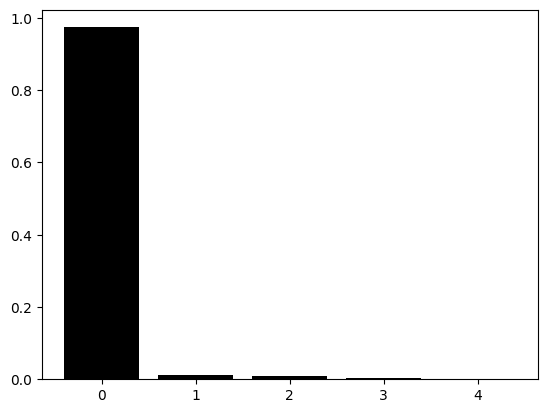

In [40]:
pca = dd.PCA ( n_components= X.shape[1] )

principal_components = pca.fit_transform ( X )

#plot Explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame( principal_components )

<Axes: xlabel='0', ylabel='1'>

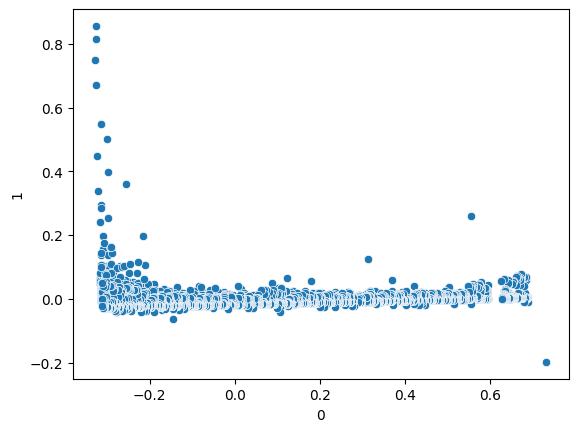

In [41]:
sns.scatterplot ( x=0, y=1, data=df_pca)

### 4.3.2. UMAP

/home/tiago/.pyenv/versions/3.8.0/envs/insiders/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


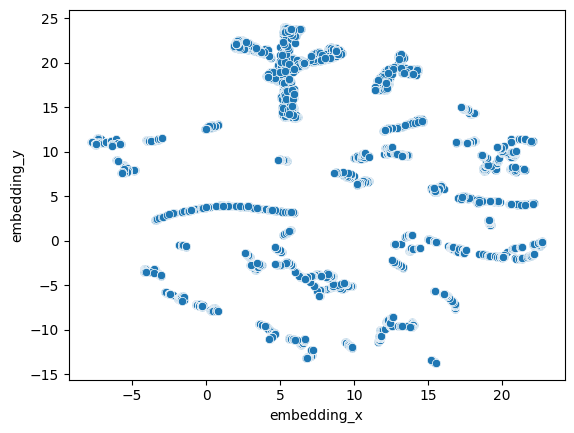

In [42]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

#plot
sns.scatterplot( x='embedding_x', y='embedding_y',
                data=df_umap);

### 4.3.3. t-SNE

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

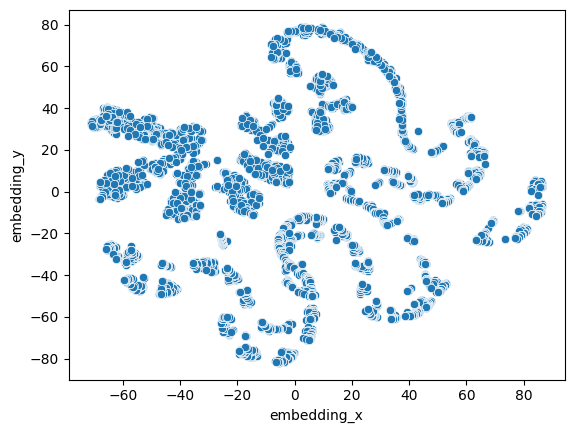

In [43]:
reducer = TSNE( n_components=2, n_jobs=-1,random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

#plot
sns.scatterplot( x='embedding_x', y='embedding_y',
                data=df_tsne)

### 4.3.4. Tree-Based Embedding

In [44]:
# training dataset
X = df4.drop( columns=['gross_revenue'], axis=1)
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit( X, y )

# Leaf

# dataframe Leaf
df_leaf = pd.DataFrame( rf_model.apply( X ) )

/home/tiago/.pyenv/versions/3.8.0/envs/insiders/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/tiago/.pyenv/versions/3.8.0/envs/insiders/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

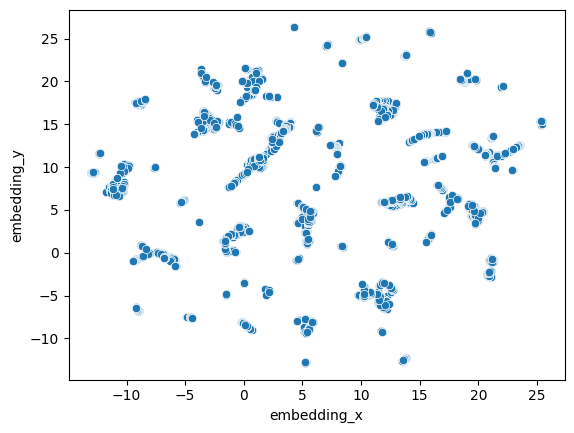

In [45]:
# reduzindo a dimensionalidade
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

#plot
sns.scatterplot( x='embedding_x', y='embedding_y',
                data=df_tree)

# <font color='red'>5.0. Data Preparation</font>

In [46]:
# Tree-Based Embedding
df5 = df_tree.copy()

# UMAP Embedding
#df5 = df_umap.copy()

# TSNE Embedding
#df5 = df_tsne.copy()

# <font color='red'>7.0. Hyperparameter Fine-Tunning</font>

In [47]:
X = df5.copy()

In [48]:
#clusters = [2, 3, 4, 5, 6, 7, 8, 9]
clusters = np.arange( 2, 25, 1)

## 7.1. K-Means

In [49]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k, n_init=100, random_state=42 )
    
    # model training
    kmeans_model.fit( X )
    
    # model predict
    labels = kmeans_model.predict( X )
    
    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean')
    kmeans_list.append( sil )

Text(0.5, 1.0, 'Silhouette Score x K')

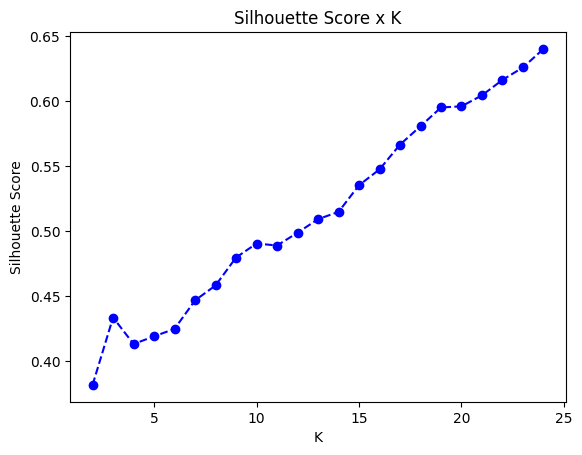

In [50]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score');
plt.title( 'Silhouette Score x K' )

## 7.2. GMM

In [51]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k, n_init=10, random_state=42 )
    
    # model training
    gmm_model.fit( X )
    
    # model predict
    labels = gmm_model.predict( X )
    
    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean')
    gmm_list.append( sil )

Text(0.5, 1.0, 'Silhouette Score x K')

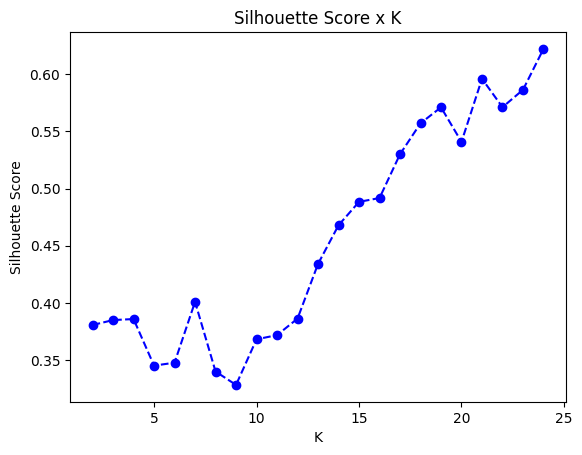

In [52]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score');
plt.title( 'Silhouette Score x K' )

## 7.3. Hierarchical Clustering

In [53]:
# model definition and training
hc_model = hc.linkage(X, 'ward' )

### 7.3.1. HClustering Silhouette Score

In [54]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )
    
    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )
    
    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean')
    hc_list.append( sil )

Text(0.5, 1.0, 'Silhouette Score x K')

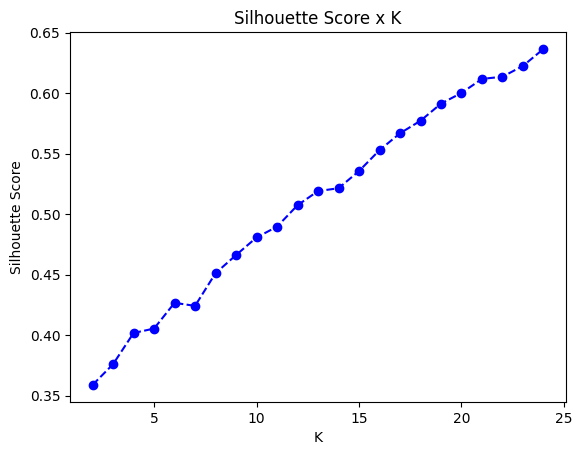

In [55]:
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score');
plt.title( 'Silhouette Score x K' )

In [99]:
## 7.5. Results - Tree Based Embedding
df_results = pd.DataFrame(
    {'Kmeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list}
).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Kmeans,0.367648,0.460202,0.458051,0.440121,0.439244,0.467595,0.486050,0.518489,0.529600,0.529447,0.524822,0.534301,0.530712,0.531275,0.535964,0.544104,0.542645,0.545900,0.562361,0.565888,0.564327,0.570891,0.581490
GMM,0.380251,0.429532,0.402878,0.396171,0.394819,0.423868,0.426517,0.467087,0.449489,0.435526,0.481677,0.429240,0.427441,0.433829,0.415912,0.494435,0.482797,0.519732,0.518536,0.537406,0.469340,0.550786,0.502743
HC,0.382178,0.420723,0.425372,0.412282,0.427954,0.459252,0.501761,0.499320,0.502613,0.518014,0.506867,0.510278,0.502656,0.515228,0.511235,0.520801,0.522595,0.526149,0.530821,0.535682,0.541711,0.548298,0.555822


In [110]:
## 7.6. Results - UMAP Embedding
df_results = pd.DataFrame(
    {'Kmeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list}
).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Kmeans,0.440712,0.468515,0.480087,0.463209,0.455744,0.457584,0.472404,0.486295,0.488144,0.506071,0.510430,0.523891,0.540354,0.540044,0.542900,0.528795,0.540364,0.539810,0.553509,0.556602,0.564246,0.569689,0.572788
GMM,0.406763,0.432368,0.475550,0.419933,0.254140,0.369554,0.358952,0.323557,0.428590,0.420105,0.481080,0.456113,0.461393,0.466490,0.505482,0.440041,0.494110,0.507651,0.515428,0.499123,0.514906,0.490302,0.527739
HC,0.388978,0.450148,0.443880,0.450691,0.439218,0.406871,0.442933,0.448037,0.471143,0.491973,0.501544,0.502184,0.515971,0.525869,0.528296,0.515254,0.525228,0.536489,0.537360,0.542695,0.549070,0.549689,0.557585


In [121]:
## 7.7. Results - TSNE Embedding
df_results = pd.DataFrame(
    {'Kmeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list}
).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Kmeans,0.352204,0.391075,0.406995,0.407313,0.421849,0.423702,0.422029,0.426500,0.428827,0.445264,0.443559,0.443842,0.445922,0.448645,0.453837,0.464858,0.468475,0.466333,0.474754,0.479596,0.483555,0.483386,0.487452
GMM,0.353616,0.368886,0.387388,0.341046,0.328913,0.361048,0.395721,0.374983,0.279010,0.327052,0.264883,0.247630,0.314894,0.367622,0.389050,0.231949,0.374381,0.391803,0.405014,0.383828,0.409989,0.441377,0.403004
HC,0.339858,0.348096,0.377154,0.399633,0.374418,0.383637,0.401106,0.403413,0.384902,0.403333,0.403682,0.414272,0.412095,0.429744,0.433339,0.441740,0.450784,0.456848,0.454527,0.457949,0.471661,0.472868,0.468708


# <font color='red'>8.0. Model Training</font>

## 8.1. Final model

In [56]:
k = 8
# model definition
gmm_model = mx.GaussianMixture( n_components=k, random_state=42 )

# model training
gmm_model.fit( X )

# model predict
labels = gmm_model.predict( X )

### 8.1.0. Cluster Validation

In [57]:
# WSS (Within-Cluster Sum of Square)
#print( f'WSS value: {kmeans.inertia_}')

# SS (Silhouette Score)
print( f'SS value: {m.silhouette_score( X, labels, metric="euclidean" )}' )

SS value: 0.43982574343681335


# <font color='red'>9.0. Cluster Analysis</font>

In [58]:
df9 = X.copy()
df9['cluster'] = labels

## 9.1. Visualization Inspection

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

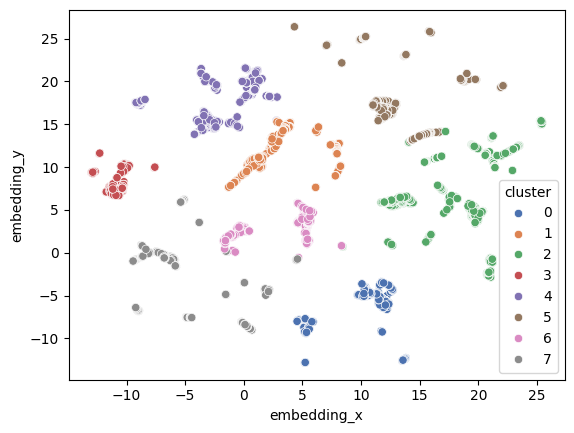

In [59]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

## 9.2. Cluster Profile

In [60]:
df92 = df4.copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtde_produtcs,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,4
1,13047,3232.59,56.0,171.0,0.028302,35.0,4
2,12583,6705.38,2.0,232.0,0.040323,50.0,4
3,13748,948.25,95.0,28.0,0.017921,0.0,2
4,15100,876.00,333.0,3.0,0.073171,22.0,0


In [61]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100 * ( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# AVG gross_revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby ('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# AVG recency_days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby ('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster')

# AVG qtde_produtcs
df_qtde_produtcs = df92[['qtde_produtcs', 'cluster']].groupby ('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_produtcs, how='inner', on='cluster')

# AVG frequency
df_frequency = df92[['frequency', 'cluster']].groupby ('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster')

# AVG qtde_returns
df_qtde_returns = df92[['qtde_returns', 'cluster']].groupby ('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster')

df_cluster.sort_values(by='gross_revenue', ascending=False)


,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_produtcs,frequency,qtde_returns
4,4,874,15.346795,6232.066670,68.747140,305.638444,0.326478,176.508009
1,1,722,12.677788,1867.053934,101.105263,159.531856,0.461950,0.785319
3,3,361,6.338894,1252.126482,60.268698,54.382271,0.027892,8.975069
6,6,564,9.903424,1215.027571,136.404255,68.001773,0.753051,2.810284
5,5,669,11.747147,1127.006726,145.686099,42.375187,0.936321,6.186846
0,0,602,10.570676,872.564950,85.318937,31.131229,0.059393,8.699336
7,7,604,10.605795,857.184222,113.902318,38.422185,0.447304,5.884106
2,2,1299,22.809482,288.830685,166.675135,12.896844,0.870556,4.220939


In [68]:
# 4 Cluster Insiders
# 1 Cluster More Products
# 3 Cluster Spend Money
# 6 Cluster Even More Products
# 5 Cluster Less Days
# 0 Cluster Less 1k
# 7 Cluster Stop Returners
# 2 Cluster More Buy

### Cluster 01:
    - Número de customers: 464 (16% do custormers)
    - Faturamento médio: $10.927,33
    - Recência média: 23 dias
    - Média de produtos comprados: 359 produtos
    - Frequência de produtos comprados: 0.06 compras/dia
    - Devoluções em média: 155 produtos

### Cluster 02:
    - Número de customers: xxx (xx% do custormers)
    - Faturamento médio: $xxxxx
    - Recência média: xx dias
    - Frequência de produtos comprados: x.xx compras/dia
    - Devoluções em média: xxx produtos

### Cluster 03:
    - Número de customers: xxx (xx% do custormers)
    - Faturamento médio: $xxxxx
    - Recência média: xx dias
    - Frequência de produtos comprados: x.xx compras/dia
    - Devoluções em média: xxx produtos

### Cluster 04:
    - Número de customers: xxx (xx% do custormers)
    - Faturamento médio: $xxxxx
    - Recência média: xx dias
    - Frequência de produtos comprados: x.xx compras/dia
    - Devoluções em média: xxx produtos

### Cluster 05:
    - Número de customers: xxx (xx% do custormers)
    - Faturamento médio: $xxxxx
    - Recência média: xx dias
    - Frequência de produtos comprados: x.xx compras/dia
    - Devoluções em média: xxx produtos

### Cluster 06:
    - Número de customers: xxx (xx% do custormers)
    - Faturamento médio: $xxxxx
    - Recência média: xx dias
    - Frequência de produtos comprados: x.xx compras/dia
    - Devoluções em média: xxx produtos

### Cluster 07:
    - Número de customers: xxx (xx% do custormers)
    - Faturamento médio: $xxxxx
    - Recência média: xx dias
    - Frequência de produtos comprados: x.xx compras/dia
    - Devoluções em média: xxx produtos

### Cluster 08:
    - Número de customers: xxx (xx% do custormers)
    - Faturamento médio: $xxxxx
    - Recência média: xx dias
    - Frequência de produtos comprados: x.xx compras/dia
    - Devoluções em média: xxx produtos

# <font color='red'>10.0. Análise Exploratoria de Dados</font>

In [65]:
df10 = df92.copy()

# <font color='red'>11.0. Deploy To Production</font>

In [66]:
df92.dtypes

customer_id        int64
gross_revenue    float64
recency_days     float64
qtde_produtcs    float64
frequency        float64
qtde_returns     float64
cluster            int64
dtype: object

In [67]:
df92['recency_days'] = df92['recency_days'].astype( int )
df92['qtde_produtcs'] = df92['qtde_produtcs'].astype( int )
df92['qtde_returns'] = df92['qtde_returns'].astype( int )

In [75]:
# database conection
conn = create_engine( 'sqlite:///insiders_db.sqlite' )

# drop table
query_drop_insiders = '''
    DROP TABLE insiders
'''

# create table
query_create_insiders = '''
    CREATE TABLE insiders(
        customer_id      INTEGER,
        gross_revenue    REAL,
        recency_days     INTEGER,
        qtde_produtcs    INTEGER,
        frequency        REAL,
        qtde_returns     INTEGER,
        cluster          INTEGER        
    )
'''

with conn.connect() as connection:
    connection.execute( text(query_create_insiders) )

In [77]:
#insert data
df92.to_sql( 'insiders', con=conn, if_exists='append', index=False )

5695

In [78]:
## get query
#query_collect = '''
#    SELECT * FROM insiders
#'''
#
#df = pd.read_sql_query( query_collect, conn )
#df.head()

,customer_id,gross_revenue,recency_days,qtde_produtcs,frequency,qtde_returns,cluster
0,17850,5391.21,372,297,17.000000,40,4
1,13047,3232.59,56,171,0.028302,35,4
2,12583,6705.38,2,232,0.040323,50,4
3,13748,948.25,95,28,0.017921,0,2
4,15100,876.00,333,3,0.073171,22,0
